In [1]:
# import trax
# from trax import layers as tl
# import trax.fastmath.numpy as fastnp
# from trax.supervised import training
from functools import partial
import numpy as np
from itertools import combinations
import random as rnd
from random import sample
import json
import sklearn.metrics as metrics
from sklearn.metrics import classification_report , confusion_matrix, roc_auc_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import copy
import torch
import os
import warnings
from scipy.spatial import distance
from os import walk
from transformers import AutoTokenizer, AutoModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#initialize codebert
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model_codebert = AutoModel.from_pretrained("microsoft/codebert-base").to(device)
np.random.seed(777)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from os import walk

from transformers import AutoModelForCausalLM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:

int_to_label_pre = {
    0: 'notFlaky',
    1: 'Flaky',
    
}

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming 'data' is your DataFrame that includes all the data
# Load the dataset
file_path = "/home/riddhi/FlakyXbert/MAIN/data/IDoFT_data/Flakify_IDoFT_dataset.csv"
data = pd.read_csv(file_path)


# Extract the relevant fields: 'preprocessed_code' and 'category'
relevant_data = data[['preprocessed_code', 'flaky']]

# Split the data into training and validation sets, stratifying by 'category' to ensure all categories are represented
train_data, valid_data = train_test_split(relevant_data, test_size=0.2, random_state=42, stratify=relevant_data['flaky'])


# Replace category numbers with category labels
train_data['category'] = train_data['flaky'].map(int_to_label_pre)
valid_data['category'] = valid_data['flaky'].map(int_to_label_pre)

# Extract buggy code and categories for train and validation sets
train_buggy_code = train_data['preprocessed_code'].tolist()
valid_buggy_code = valid_data['preprocessed_code'].tolist()
train_categories = train_data['category'].tolist()
valid_categories = valid_data['category'].tolist()

# Print the splits for verification
print("Train buggy code:", len(train_buggy_code))
print("Validation buggy code:", len(valid_buggy_code))
print("Train categories:", len(train_categories))
print("Validation categories:", len(valid_categories))


Train buggy code: 3050
Validation buggy code: 763
Train categories: 3050
Validation categories: 763


In [10]:
label_to_int= {
    'notFlaky': 0,
    'Flaky': 1
    }

In [11]:
from torch.utils.data import Dataset
import numpy as np
import random
import torch

class SiameseDataset(Dataset):
    def __init__(self, train_buggy_code, valid_buggy_code, tokenizer, codebert, categories, split):
        self.train_buggy_code = train_buggy_code
        self.valid_buggy_code = valid_buggy_code
        self.tokenizer = tokenizer
        self.codebert = codebert.to(device)
        self.categories = categories
        self.split = split
        self.m_len = self.calculate_max_output_length()
        
        # Preprocess categories to map labels to indices
        self.label_to_indices = {}
        for index, category in enumerate(categories):
            if category not in self.label_to_indices:
                self.label_to_indices[category] = []
            self.label_to_indices[category].append(index)

        # For negative sampling
        self.labels = categories
        self.unique_labels = list(set(self.labels))
        
    def calculate_max_output_length(self):
        max_length = 0
        for code in self.train_buggy_code:
            # Simulate processing of snippets to determine the concatenated output length
            length = self.simulate_process_length(code)
            if length > max_length:
                max_length_train = length
        for code in self.valid_buggy_code:
            # Simulate processing of snippets to determine the concatenated output length
            length = self.simulate_process_length(code)
            if length > max_length:
                max_length_valid = length
        if max_length_train > max_length_valid:
            return max_length_train
        else:
            return max_length_valid

    def simulate_process_length(self, snippet):
        # Calculate how many segments would be needed
        encoded_input = self.tokenizer.encode(snippet, add_special_tokens=True)
        # Each segment processes up to 512 tokens (max length for BERT models)
        num_segments = (len(encoded_input) + 511) // 512  # 512 tokens per segment, including CLS and SEP
        return num_segments * 768
    def __len__(self):
        if self.split == 'train':
            return len(self.train_buggy_code)
        else:
            return len(self.valid_buggy_code)

    def __getitem__(self, idx):
        if self.split == 'train':
            # Anchor label
            anchor_label = self.categories[idx]

            # Positive sample
            positive_idx = idx
            while positive_idx == idx:  # Ensure different indices for anchor and positive
                positive_idx = random.choice(self.label_to_indices[anchor_label])

            # Negative sample
            negative_label = random.choice([lab for lab in self.unique_labels if lab != anchor_label])
            negative_idx = random.choice(self.label_to_indices[negative_label])

            anchor = self._process_snippet(self.train_buggy_code[idx])
            positive = self._process_snippet(self.train_buggy_code[positive_idx])
            negative = self._process_snippet(self.train_buggy_code[negative_idx])
            
            if len(anchor) <= 768:
                short_data = True
            else:
                short_data = False
                


            return {
                'anchor': torch.nn.functional.pad(anchor, (0, self.m_len - anchor.size(0))),
                'positive':torch.nn.functional.pad(positive, (0, self.m_len - positive.size(0))),
                'negative': torch.nn.functional.pad(negative, (0, self.m_len - negative.size(0))),
                'label': label_to_int[anchor_label],  # Optional, depends on how you want to use it
                'short_data_flag': short_data
            }
        elif self.split == 'val':
            anchor_label = self.categories[idx]
            anchor = self._process_snippet(self.valid_buggy_code[idx])
            
            return {
                'anchor': torch.nn.functional.pad(anchor, (0, self.m_len - anchor.size(0))),
                'label': label_to_int[anchor_label]  # Optional, depends on how you want to use it
            }

        
    def _process_snippet(self, snippet):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Tokenize input without the max_length constraint
        inputs = self.tokenizer(snippet, return_tensors='pt').to(device)

        if inputs['input_ids'].shape[1] < 512:
            with torch.no_grad():
                outs = self.codebert(**inputs)
            cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
            return cls  # Move to CPU to save GPU memory
        else:
            total_length = inputs['input_ids'].shape[1]
            parts = []
            step_size = 100
            chunk_size = 512

            for start_index in range(0, total_length, step_size):
                end_index = min(start_index + chunk_size, total_length)
                input_segment = {key: val[:, start_index:end_index].to(device) for key, val in inputs.items()}

                with torch.no_grad():
                    output_segment = self.codebert(**input_segment)
                cls_segment = output_segment.last_hidden_state[:, 0, :].squeeze().detach()
                parts.append(cls_segment)  # Move to CPU

            concatenated_parts = torch.cat(parts, dim=0)
            return concatenated_parts

In [12]:
# Create instances of the custom dataset class
train_dataset = SiameseDataset(train_buggy_code, valid_buggy_code, tokenizer, model_codebert, train_categories, 'train')
val_dataset = SiameseDataset(train_buggy_code, valid_buggy_code, tokenizer, model_codebert, valid_categories, 'val')

# Create dataloaders for training and validation
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Print the lengths of the dataloaders for verification
print("Train dataloader length:", len(train_dataloader))
print("Validation dataloader length:", len(val_dataloader))

Token indices sequence length is longer than the specified maximum sequence length for this model (600 > 512). Running this sequence through the model will result in indexing errors


Train dataloader length: 382
Validation dataloader length: 96


In [13]:
import numpy as np

def sample_triplet_data(data, sample_size_ratio):
    """
    Samples a subset of triplet data (anchor, positive, negative) while preserving class distribution.
    
    Parameters:
    - data: list of dictionaries, where each dictionary has keys 'anchor', 'positive', 'negative', 'label'.
    - sample_size_ratio: float, the fraction of the data to sample (0 < sample_size_ratio <= 1).
    
    Returns:
    - sampled_data: list of dictionaries, the sampled subset of the original data.
    """
    # Extract labels to understand the class distribution
    labels = [item['label'] for item in data]
    unique_classes = np.unique(labels)
    
    sampled_data = []
    
    for cls in unique_classes:
        # Find all items belonging to the current class
        class_items = [item for item in data if item['label'] == cls]
        # Calculate the number of items to sample from this class
        num_samples = int(np.ceil(len(class_items) * sample_size_ratio))
        # Randomly sample items without replacement
        sampled_items = np.random.choice(class_items, size=num_samples, replace=False)
        # Append the sampled items to the output list
        sampled_data.extend(sampled_items)
    
    # Optionally, shuffle the sampled dataset to mix classes
    np.random.shuffle(sampled_data)

    return sampled_data


In [14]:
import gc
from tqdm import tqdm
plot_data = []
plot_labels = []
short_data_flags = []
for item in tqdm(train_dataset):
    
    plot_data.append(item['anchor'])
    plot_labels.append(item['label'])
    short_data_flags.append(item['short_data_flag'])

100%|██████████| 3050/3050 [00:29<00:00, 102.29it/s]


In [15]:
m_len = plot_data[0].shape[0]

In [16]:
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid', 'grey']  
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# Create a custom colormap
cc = LinearSegmentedColormap.from_list("cc", colors, N=5)


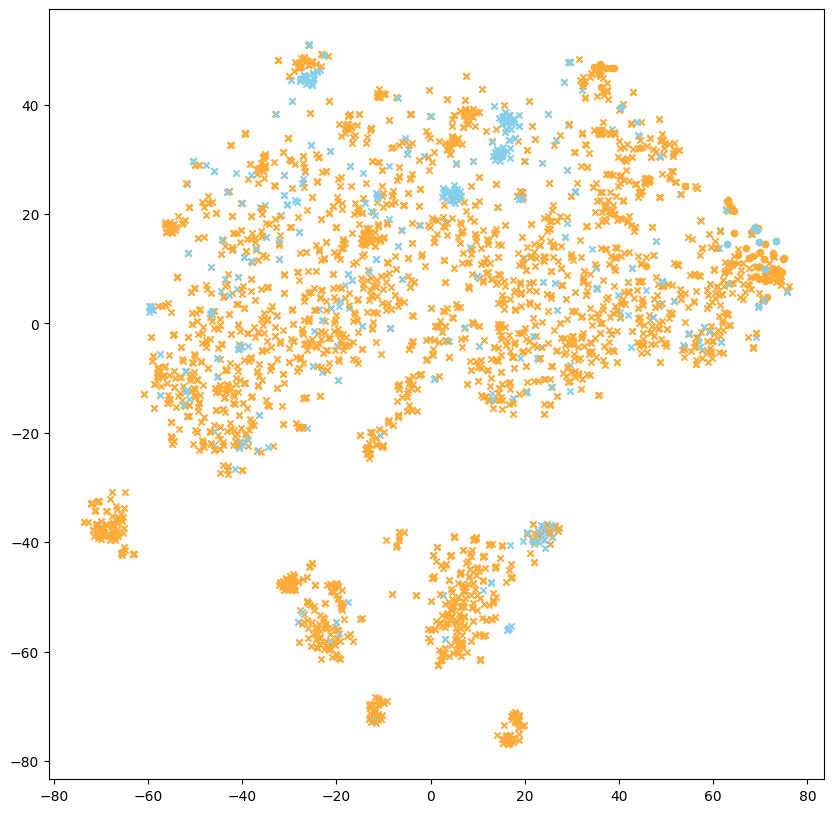

In [17]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import numpy as np

# Assuming X, plot_data, and plot_labels are defined as before
# Also assuming bool_values is your list/array of boolean values

X = torch.stack(plot_data).cpu().numpy()

# Extract labels for each point
labelsNums = plot_labels

# Perform t-SNE dimensionality reduction
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

# Assuming 'cc' is a colormap, you might need to adjust this to fit your actual colormap variable
# Generate an array of colors for each label
unique_labels = np.unique(labelsNums)
colors = plt.cm.get_cmap(cc, len(unique_labels))  # Adjust 'cc' as needed to your colormap name
label_to_color = {label: colors(i / len(unique_labels)) for i, label in enumerate(unique_labels)}
colors_array = np.array([label_to_color[label] for label in labelsNums])

# Create the scatter plot
plt.figure(figsize=(10, 10))

# Iterate through each datapoint
for i in range(len(X_embedded)):
    marker = 'x' if short_data_flags[i] else 'o'  # Choose the marker based on the boolean value
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors_array[i], s=20, alpha=1, marker=marker)

# Set the background color to black
# plt.gca().set_facecolor('white')
# # Adjust the color of the ticks and labels for better visibility
# plt.tick_params(axis='x', colors='white')
# plt.tick_params(axis='y', colors='white')
# plt.xlabel('Component 1', color='white')
# plt.ylabel('Component 2', color='white')

plt.show()


In [18]:
# Load the CodeBERT tokenizer (adjust the model_name as needed)
model_name = "microsoft/codebert-base"
codebert_model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


class SiameseNetwork(nn.Module):
    def __init__(self, embedding_size):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(embedding_size, int(embedding_size/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(embedding_size/2), int(embedding_size/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(embedding_size/4), embedding_size)
        )

    def forward(self, x):
        output = self.fc(x)
        return output

In [19]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [20]:
learning_rate = 1e-5
num_epochs = 450
embed_size = m_len  # This should match the output size of CodeBERT
siamese_network = SiameseNetwork(embed_size).to(device)
criterion = TripletLoss(margin=1.0)
optimizer = optim.Adam(siamese_network.parameters(), lr=learning_rate)
triplet_loss = TripletLoss().to(device)

In [20]:
# from transformers import get_linear_schedule_with_warmup
# warmup_Frac = 0.1
# total_iter = num_epochs * len(train_dataloader)
# scheduler = get_linear_schedule_with_warmup(optimizer, int(warmup_Frac * total_iter), total_iter)

In [36]:
from tqdm import tqdm
best_loss = 100.0
num_epochs = 200
epoch_loss_list = []
model_name = "binaryIDoFT.pth"
for epoch in range(num_epochs):
    total_loss = 0.0
    siamese_network.train()
    for batch in tqdm(train_dataloader):

        labels = (batch['label']).to(device)
        batch_anchor = (batch['anchor']).to(device)
        batch_positive = (batch['positive']).to(device)
        batch_negative = (batch['negative']).to(device)

        anchor_output = siamese_network(batch_anchor)
        positive_out = siamese_network(batch_positive)
        negative_out = siamese_network(batch_negative)

        loss = criterion(anchor_output, positive_out, negative_out)
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(siamese_network.parameters(), max_norm=2.0)        
        optimizer.step()
        # scheduler.step()

        total_loss += loss.item()
        if total_loss <= best_loss:
            # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
            print("Loss improved saving model")
            torch.save(siamese_network.state_dict(), model_name)
            best_loss = total_loss
        
            
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
    # The line `epoch_loss_list.append(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")` is attempting to append a formatted string to a list named `epoch_loss_list`. This string contains information about the current epoch number, total number of epochs, and the average loss calculated for that epoch. However, in the provided code snippet, the `epoch_loss_list` list is not defined or used anywhere else in the code.
    epoch_loss_list.append(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
    

  1%|          | 2/382 [00:00<00:28, 13.49it/s]

Loss improved saving model


100%|██████████| 382/382 [00:30<00:00, 12.49it/s]


Epoch 1/200, Loss: 0.20235486186221632


  1%|          | 2/382 [00:00<00:22, 16.71it/s]

Loss improved saving model


100%|██████████| 382/382 [00:31<00:00, 12.14it/s]


Epoch 2/200, Loss: 0.18035995503838773


  1%|          | 2/382 [00:00<00:26, 14.48it/s]

Loss improved saving model


100%|██████████| 382/382 [00:31<00:00, 12.19it/s]


Epoch 3/200, Loss: 0.20465488312522154


  1%|          | 2/382 [00:00<00:36, 10.35it/s]

Loss improved saving model


100%|██████████| 382/382 [00:31<00:00, 12.19it/s]


Epoch 4/200, Loss: 0.18518285734179132


100%|██████████| 382/382 [00:31<00:00, 12.22it/s]


Epoch 5/200, Loss: 0.19342599518558118


100%|██████████| 382/382 [00:32<00:00, 11.72it/s]


Epoch 6/200, Loss: 0.19972605392804946


100%|██████████| 382/382 [00:31<00:00, 12.31it/s]


Epoch 7/200, Loss: 0.18685764054821424


  1%|          | 2/382 [00:00<00:22, 16.82it/s]

Loss improved saving model


100%|██████████| 382/382 [00:32<00:00, 11.59it/s]


Epoch 8/200, Loss: 0.2021975048783562


100%|██████████| 382/382 [00:30<00:00, 12.40it/s]


Epoch 9/200, Loss: 0.18371623534104586


  1%|          | 2/382 [00:00<00:22, 16.82it/s]

Loss improved saving model


100%|██████████| 382/382 [00:30<00:00, 12.62it/s]


Epoch 10/200, Loss: 0.1830968744272649


100%|██████████| 382/382 [00:31<00:00, 12.19it/s]


Epoch 11/200, Loss: 0.18122947711439033


100%|██████████| 382/382 [00:30<00:00, 12.46it/s]


Epoch 12/200, Loss: 0.17691250110327886


100%|██████████| 382/382 [00:32<00:00, 11.82it/s]


Epoch 13/200, Loss: 0.1955646491799679


100%|██████████| 382/382 [00:31<00:00, 12.16it/s]


Epoch 14/200, Loss: 0.1869240384646423


100%|██████████| 382/382 [00:32<00:00, 11.80it/s]


Epoch 15/200, Loss: 0.18182791707091306


100%|██████████| 382/382 [00:31<00:00, 12.00it/s]


Epoch 16/200, Loss: 0.1856966254286741


100%|██████████| 382/382 [00:31<00:00, 12.06it/s]


Epoch 17/200, Loss: 0.18209075520097898


100%|██████████| 382/382 [00:30<00:00, 12.50it/s]


Epoch 18/200, Loss: 0.1900966179737558


  1%|          | 2/382 [00:00<00:35, 10.78it/s]

Loss improved saving model


100%|██████████| 382/382 [00:30<00:00, 12.42it/s]


Epoch 19/200, Loss: 0.1794821124192308


100%|██████████| 382/382 [00:31<00:00, 11.99it/s]


Epoch 20/200, Loss: 0.19117519614428125


100%|██████████| 382/382 [00:31<00:00, 12.12it/s]


Epoch 21/200, Loss: 0.18292472952323435


  1%|          | 2/382 [00:00<00:26, 14.54it/s]

Loss improved saving model


100%|██████████| 382/382 [00:31<00:00, 12.16it/s]


Epoch 22/200, Loss: 0.17707005344058208


100%|██████████| 382/382 [00:32<00:00, 11.78it/s]


Epoch 23/200, Loss: 0.18384420083767455


100%|██████████| 382/382 [00:31<00:00, 12.26it/s]


Epoch 24/200, Loss: 0.18165935217085932


100%|██████████| 382/382 [00:32<00:00, 11.59it/s]


Epoch 25/200, Loss: 0.1887956864702764


100%|██████████| 382/382 [00:30<00:00, 12.52it/s]


Epoch 26/200, Loss: 0.1851277844834078


100%|██████████| 382/382 [00:31<00:00, 12.19it/s]


Epoch 27/200, Loss: 0.17738304649972167


  1%|          | 2/382 [00:00<00:22, 17.17it/s]

Loss improved saving model


100%|██████████| 382/382 [00:32<00:00, 11.77it/s]


Epoch 28/200, Loss: 0.18042499850947818


100%|██████████| 382/382 [00:30<00:00, 12.44it/s]


Epoch 29/200, Loss: 0.17980436428757238


  1%|          | 2/382 [00:00<00:27, 14.05it/s]

Loss improved saving model


100%|██████████| 382/382 [00:30<00:00, 12.63it/s]


Epoch 30/200, Loss: 0.17046395375232423


100%|██████████| 382/382 [00:32<00:00, 11.88it/s]


Epoch 31/200, Loss: 0.1837450105755429


  1%|          | 2/382 [00:00<00:22, 16.60it/s]

Loss improved saving model


100%|██████████| 382/382 [00:32<00:00, 11.82it/s]


Epoch 32/200, Loss: 0.18951962654191162


  1%|          | 2/382 [00:00<00:23, 16.47it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 382/382 [00:31<00:00, 12.14it/s]


Epoch 33/200, Loss: 0.20647513016044158


100%|██████████| 382/382 [00:31<00:00, 12.21it/s]


Epoch 34/200, Loss: 0.17749939410318255


100%|██████████| 382/382 [00:32<00:00, 11.93it/s]


Epoch 35/200, Loss: 0.18825398258747855


100%|██████████| 382/382 [00:30<00:00, 12.39it/s]


Epoch 36/200, Loss: 0.18586529247189693


100%|██████████| 382/382 [00:30<00:00, 12.51it/s]


Epoch 37/200, Loss: 0.1900202336852775


  0%|          | 0/382 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 382/382 [00:32<00:00, 11.86it/s]


Epoch 38/200, Loss: 0.18166967510630946


100%|██████████| 382/382 [00:30<00:00, 12.34it/s]


Epoch 39/200, Loss: 0.17065624724976056


  1%|          | 2/382 [00:00<00:26, 14.55it/s]

Loss improved saving model


100%|██████████| 382/382 [00:31<00:00, 12.28it/s]


Epoch 40/200, Loss: 0.17358663479227046


100%|██████████| 382/382 [00:32<00:00, 11.92it/s]


Epoch 41/200, Loss: 0.19658703981113684


100%|██████████| 382/382 [00:31<00:00, 12.25it/s]


Epoch 42/200, Loss: 0.16934884296661895


  1%|          | 2/382 [00:00<00:23, 16.12it/s]

Loss improved saving model


100%|██████████| 382/382 [00:31<00:00, 12.30it/s]


Epoch 43/200, Loss: 0.17997439330472997


100%|██████████| 382/382 [00:31<00:00, 12.16it/s]


Epoch 44/200, Loss: 0.1659558615135273


100%|██████████| 382/382 [00:31<00:00, 12.09it/s]


Epoch 45/200, Loss: 0.17712262668768772


100%|██████████| 382/382 [00:31<00:00, 12.03it/s]


Epoch 46/200, Loss: 0.17051414312570506


100%|██████████| 382/382 [00:31<00:00, 12.19it/s]


Epoch 47/200, Loss: 0.18169608062708564


  1%|          | 2/382 [00:00<00:27, 13.74it/s]

Loss improved saving model


100%|██████████| 382/382 [00:30<00:00, 12.56it/s]


Epoch 48/200, Loss: 0.186615545517175


100%|██████████| 382/382 [00:30<00:00, 12.64it/s]


Epoch 49/200, Loss: 0.16130009816267105


  1%|          | 2/382 [00:00<00:22, 17.13it/s]

Loss improved saving model


100%|██████████| 382/382 [00:30<00:00, 12.45it/s]


Epoch 50/200, Loss: 0.18968535431158481


100%|██████████| 382/382 [00:31<00:00, 12.03it/s]


Epoch 51/200, Loss: 0.18072306552014425


  1%|          | 2/382 [00:00<00:22, 16.73it/s]

Loss improved saving model


100%|██████████| 382/382 [00:31<00:00, 12.12it/s]


Epoch 52/200, Loss: 0.1804928084669625


100%|██████████| 382/382 [00:31<00:00, 12.03it/s]


Epoch 53/200, Loss: 0.18164565642388703


100%|██████████| 382/382 [00:32<00:00, 11.92it/s]


Epoch 54/200, Loss: 0.17693454140299902


100%|██████████| 382/382 [00:29<00:00, 12.81it/s]


Epoch 55/200, Loss: 0.1730227989403053


  1%|          | 2/382 [00:00<00:21, 17.77it/s]

Loss improved saving model


100%|██████████| 382/382 [00:30<00:00, 12.46it/s]


Epoch 56/200, Loss: 0.16633105127833275


  0%|          | 1/382 [00:00<00:39,  9.72it/s]

Loss improved saving model


100%|██████████| 382/382 [00:31<00:00, 12.14it/s]


Epoch 57/200, Loss: 0.16670474796238993


100%|██████████| 382/382 [00:31<00:00, 12.10it/s]


Epoch 58/200, Loss: 0.1901581748461848


100%|██████████| 382/382 [00:32<00:00, 11.79it/s]


Epoch 59/200, Loss: 0.18302732362797122


100%|██████████| 382/382 [00:31<00:00, 12.05it/s]


Epoch 60/200, Loss: 0.1791122011762327


100%|██████████| 382/382 [00:30<00:00, 12.69it/s]


Epoch 61/200, Loss: 0.17209479813488365


100%|██████████| 382/382 [00:30<00:00, 12.66it/s]


Epoch 62/200, Loss: 0.17292869001314903


100%|██████████| 382/382 [00:31<00:00, 11.95it/s]


Epoch 63/200, Loss: 0.1676176690462372


  1%|          | 2/382 [00:00<00:27, 13.91it/s]

Loss improved saving model
Loss improved saving model
Loss improved saving model


100%|██████████| 382/382 [00:31<00:00, 12.22it/s]


Epoch 64/200, Loss: 0.17270067398538763


100%|██████████| 382/382 [00:33<00:00, 11.46it/s]


Epoch 65/200, Loss: 0.17484597896874263


100%|██████████| 382/382 [00:32<00:00, 11.75it/s]


Epoch 66/200, Loss: 0.17867552561207592


  1%|          | 2/382 [00:00<00:36, 10.40it/s]

Loss improved saving model


100%|██████████| 382/382 [00:30<00:00, 12.50it/s]


Epoch 67/200, Loss: 0.17129881999879606


100%|██████████| 382/382 [00:32<00:00, 11.85it/s]


Epoch 68/200, Loss: 0.16734289132175645


100%|██████████| 382/382 [00:31<00:00, 12.14it/s]


Epoch 69/200, Loss: 0.16443121189456336


  1%|          | 3/382 [00:00<00:39,  9.56it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 382/382 [00:32<00:00, 11.87it/s]


Epoch 70/200, Loss: 0.1682833181547869


100%|██████████| 382/382 [00:31<00:00, 12.32it/s]


Epoch 71/200, Loss: 0.1855773612154716


100%|██████████| 382/382 [00:31<00:00, 11.98it/s]


Epoch 72/200, Loss: 0.16620672082635746


100%|██████████| 382/382 [00:31<00:00, 11.99it/s]


Epoch 73/200, Loss: 0.17176522911375106


100%|██████████| 382/382 [00:31<00:00, 12.23it/s]


Epoch 74/200, Loss: 0.1673662141745627


100%|██████████| 382/382 [00:32<00:00, 11.80it/s]


Epoch 75/200, Loss: 0.16918237499541638


100%|██████████| 382/382 [00:31<00:00, 12.11it/s]


Epoch 76/200, Loss: 0.16968738904018052


100%|██████████| 382/382 [00:31<00:00, 12.19it/s]


Epoch 77/200, Loss: 0.18186825574302548


  1%|          | 2/382 [00:00<00:26, 14.52it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 382/382 [00:30<00:00, 12.37it/s]


Epoch 78/200, Loss: 0.1718044185045502


100%|██████████| 382/382 [00:31<00:00, 12.24it/s]


Epoch 79/200, Loss: 0.17244738197997603


100%|██████████| 382/382 [00:30<00:00, 12.54it/s]


Epoch 80/200, Loss: 0.1720231841098888


  1%|          | 2/382 [00:00<00:25, 15.00it/s]

Loss improved saving model


100%|██████████| 382/382 [00:31<00:00, 12.12it/s]


Epoch 81/200, Loss: 0.16528062522411346


100%|██████████| 382/382 [00:30<00:00, 12.68it/s]


Epoch 82/200, Loss: 0.17713057871966462


100%|██████████| 382/382 [00:31<00:00, 11.96it/s]


Epoch 83/200, Loss: 0.1696507478844745


100%|██████████| 382/382 [00:33<00:00, 11.49it/s]


Epoch 84/200, Loss: 0.17544138706557413


100%|██████████| 382/382 [00:31<00:00, 12.13it/s]


Epoch 85/200, Loss: 0.17433140222080715


  0%|          | 1/382 [00:00<00:40,  9.37it/s]

Loss improved saving model


100%|██████████| 382/382 [00:33<00:00, 11.43it/s]


Epoch 86/200, Loss: 0.17469794849294643


100%|██████████| 382/382 [00:31<00:00, 12.19it/s]


Epoch 87/200, Loss: 0.17577415650115588


100%|██████████| 382/382 [00:31<00:00, 12.06it/s]


Epoch 88/200, Loss: 0.17849646280495285


100%|██████████| 382/382 [00:30<00:00, 12.47it/s]


Epoch 89/200, Loss: 0.16083589047973693


100%|██████████| 382/382 [00:32<00:00, 11.82it/s]


Epoch 90/200, Loss: 0.16477816936155265


  1%|          | 2/382 [00:00<00:25, 14.77it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 382/382 [00:32<00:00, 11.91it/s]


Epoch 91/200, Loss: 0.16780867913240538


  1%|          | 2/382 [00:00<00:27, 13.82it/s]

Loss improved saving model


100%|██████████| 382/382 [00:30<00:00, 12.49it/s]


Epoch 92/200, Loss: 0.16005436020917918


100%|██████████| 382/382 [00:31<00:00, 12.04it/s]


Epoch 93/200, Loss: 0.16775537881005498


  0%|          | 1/382 [00:00<00:46,  8.13it/s]

Loss improved saving model


100%|██████████| 382/382 [00:30<00:00, 12.35it/s]


Epoch 94/200, Loss: 0.17218834895114


100%|██████████| 382/382 [00:31<00:00, 12.01it/s]


Epoch 95/200, Loss: 0.15447248563326466


100%|██████████| 382/382 [00:31<00:00, 12.10it/s]


Epoch 96/200, Loss: 0.16965355447137542


100%|██████████| 382/382 [00:32<00:00, 11.79it/s]


Epoch 97/200, Loss: 0.15526750978296963


  1%|          | 2/382 [00:00<00:21, 17.44it/s]

Loss improved saving model


100%|██████████| 382/382 [00:31<00:00, 12.31it/s]


Epoch 98/200, Loss: 0.16881372656731705


100%|██████████| 382/382 [00:30<00:00, 12.36it/s]


Epoch 99/200, Loss: 0.17107475108189107


100%|██████████| 382/382 [00:30<00:00, 12.35it/s]


Epoch 100/200, Loss: 0.16911529203516026


100%|██████████| 382/382 [00:32<00:00, 11.84it/s]


Epoch 101/200, Loss: 0.16411579708466356


  0%|          | 0/382 [00:00<?, ?it/s]

Loss improved saving model


100%|██████████| 382/382 [00:30<00:00, 12.47it/s]


Epoch 102/200, Loss: 0.17253507634732113


100%|██████████| 382/382 [00:32<00:00, 11.79it/s]


Epoch 103/200, Loss: 0.16105690409297718


100%|██████████| 382/382 [00:31<00:00, 12.27it/s]


Epoch 104/200, Loss: 0.1710235400232657


100%|██████████| 382/382 [00:32<00:00, 11.82it/s]


Epoch 105/200, Loss: 0.16894189426334116


100%|██████████| 382/382 [00:31<00:00, 12.08it/s]


Epoch 106/200, Loss: 0.15976543155016076


  1%|          | 2/382 [00:00<00:30, 12.55it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 382/382 [00:31<00:00, 12.23it/s]


Epoch 107/200, Loss: 0.1508734887222033


100%|██████████| 382/382 [00:31<00:00, 12.07it/s]


Epoch 108/200, Loss: 0.16353520690536624


100%|██████████| 382/382 [00:32<00:00, 11.76it/s]


Epoch 109/200, Loss: 0.15935880509424585


100%|██████████| 382/382 [00:32<00:00, 11.86it/s]


Epoch 110/200, Loss: 0.16253243098084216


100%|██████████| 382/382 [00:30<00:00, 12.59it/s]


Epoch 111/200, Loss: 0.17037056129016176


  1%|          | 2/382 [00:00<00:22, 16.73it/s]

Loss improved saving model


100%|██████████| 382/382 [00:31<00:00, 12.28it/s]


Epoch 112/200, Loss: 0.16400529947424433


100%|██████████| 382/382 [00:30<00:00, 12.34it/s]


Epoch 113/200, Loss: 0.1645819049387078


  1%|          | 2/382 [00:00<00:27, 13.86it/s]

Loss improved saving model


100%|██████████| 382/382 [00:30<00:00, 12.48it/s]


Epoch 114/200, Loss: 0.163292883246825


100%|██████████| 382/382 [00:32<00:00, 11.59it/s]


Epoch 115/200, Loss: 0.17178500638738353


100%|██████████| 382/382 [00:31<00:00, 12.22it/s]


Epoch 116/200, Loss: 0.1569423492198215


  1%|          | 2/382 [00:00<00:25, 14.82it/s]

Loss improved saving model


100%|██████████| 382/382 [00:30<00:00, 12.45it/s]


Epoch 117/200, Loss: 0.15268616255431275


  0%|          | 1/382 [00:00<00:40,  9.34it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 382/382 [00:32<00:00, 11.92it/s]


Epoch 118/200, Loss: 0.16107405944488434


100%|██████████| 382/382 [00:31<00:00, 12.22it/s]


Epoch 119/200, Loss: 0.1652230557580893


  0%|          | 1/382 [00:00<00:38,  9.97it/s]

Loss improved saving model


100%|██████████| 382/382 [00:32<00:00, 11.87it/s]


Epoch 120/200, Loss: 0.16189331303872362


100%|██████████| 382/382 [00:31<00:00, 11.98it/s]


Epoch 121/200, Loss: 0.17387340022787373


  1%|          | 2/382 [00:00<00:26, 14.38it/s]

Loss improved saving model
Loss improved saving model
Loss improved saving model


100%|██████████| 382/382 [00:31<00:00, 12.15it/s]


Epoch 122/200, Loss: 0.17716013456826435


  1%|          | 2/382 [00:00<00:31, 11.98it/s]

Loss improved saving model


100%|██████████| 382/382 [00:31<00:00, 12.05it/s]


Epoch 123/200, Loss: 0.17100427693721512


100%|██████████| 382/382 [00:30<00:00, 12.33it/s]


Epoch 124/200, Loss: 0.17547458917370642


100%|██████████| 382/382 [00:30<00:00, 12.46it/s]


Epoch 125/200, Loss: 0.1632882285843657


100%|██████████| 382/382 [00:30<00:00, 12.42it/s]


Epoch 126/200, Loss: 0.15875894935187246


  1%|          | 2/382 [00:00<00:36, 10.32it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 382/382 [00:31<00:00, 12.20it/s]


Epoch 127/200, Loss: 0.16007729918154748


100%|██████████| 382/382 [00:32<00:00, 11.89it/s]


Epoch 128/200, Loss: 0.16380491092098945


100%|██████████| 382/382 [00:31<00:00, 12.18it/s]


Epoch 129/200, Loss: 0.15894520362712325


100%|██████████| 382/382 [00:30<00:00, 12.53it/s]


Epoch 130/200, Loss: 0.1550927273929119


100%|██████████| 382/382 [00:31<00:00, 11.95it/s]


Epoch 131/200, Loss: 0.15693578982228384


100%|██████████| 382/382 [00:31<00:00, 12.19it/s]


Epoch 132/200, Loss: 0.17345949110248327


100%|██████████| 382/382 [00:31<00:00, 12.28it/s]


Epoch 133/200, Loss: 0.15501149975894635


100%|██████████| 382/382 [00:31<00:00, 12.20it/s]


Epoch 134/200, Loss: 0.15301391180039076


100%|██████████| 382/382 [00:32<00:00, 11.76it/s]


Epoch 135/200, Loss: 0.1508494430460543


100%|██████████| 382/382 [00:30<00:00, 12.35it/s]


Epoch 136/200, Loss: 0.16589878520962456


100%|██████████| 382/382 [00:31<00:00, 12.18it/s]


Epoch 137/200, Loss: 0.1622067498950122


100%|██████████| 382/382 [00:32<00:00, 11.89it/s]


Epoch 138/200, Loss: 0.16415512493533613


100%|██████████| 382/382 [00:31<00:00, 12.17it/s]


Epoch 139/200, Loss: 0.15593083269152966


100%|██████████| 382/382 [00:30<00:00, 12.33it/s]


Epoch 140/200, Loss: 0.16993777219849732


  0%|          | 1/382 [00:00<01:03,  5.98it/s]

Loss improved saving model


  1%|          | 3/382 [00:00<00:33, 11.23it/s]

Loss improved saving model


100%|██████████| 382/382 [00:32<00:00, 11.80it/s]


Epoch 141/200, Loss: 0.16779969482443718


100%|██████████| 382/382 [00:30<00:00, 12.35it/s]


Epoch 142/200, Loss: 0.15860876598985407


100%|██████████| 382/382 [00:32<00:00, 11.75it/s]


Epoch 143/200, Loss: 0.16363200642831663


100%|██████████| 382/382 [00:31<00:00, 12.12it/s]


Epoch 144/200, Loss: 0.15149096409297738


100%|██████████| 382/382 [00:31<00:00, 12.07it/s]


Epoch 145/200, Loss: 0.15615645823366356


  1%|          | 2/382 [00:00<00:31, 12.21it/s]

Loss improved saving model


100%|██████████| 382/382 [00:30<00:00, 12.57it/s]


Epoch 146/200, Loss: 0.16021881886411712


100%|██████████| 382/382 [00:31<00:00, 12.05it/s]


Epoch 147/200, Loss: 0.15833433619968554


100%|██████████| 382/382 [00:30<00:00, 12.52it/s]


Epoch 148/200, Loss: 0.16265533462712903


100%|██████████| 382/382 [00:31<00:00, 12.21it/s]


Epoch 149/200, Loss: 0.153572394975817


100%|██████████| 382/382 [00:29<00:00, 12.75it/s]


Epoch 150/200, Loss: 0.16104522725830528


100%|██████████| 382/382 [00:32<00:00, 11.92it/s]


Epoch 151/200, Loss: 0.15047239418585262


100%|██████████| 382/382 [00:30<00:00, 12.34it/s]


Epoch 152/200, Loss: 0.15507827896176207


100%|██████████| 382/382 [00:31<00:00, 12.11it/s]


Epoch 153/200, Loss: 0.15640253284994846


  0%|          | 1/382 [00:00<00:44,  8.64it/s]

Loss improved saving model


100%|██████████| 382/382 [00:31<00:00, 12.00it/s]


Epoch 154/200, Loss: 0.15438770235599023


100%|██████████| 382/382 [00:32<00:00, 11.68it/s]


Epoch 155/200, Loss: 0.16284364177138394


100%|██████████| 382/382 [00:31<00:00, 12.25it/s]


Epoch 156/200, Loss: 0.15614005045584983


100%|██████████| 382/382 [00:31<00:00, 12.23it/s]


Epoch 157/200, Loss: 0.1434595638895846


100%|██████████| 382/382 [00:30<00:00, 12.33it/s]


Epoch 158/200, Loss: 0.1595700099986261


100%|██████████| 382/382 [00:31<00:00, 12.10it/s]


Epoch 159/200, Loss: 0.16249879332581116


  1%|          | 2/382 [00:00<00:30, 12.47it/s]

Loss improved saving model


100%|██████████| 382/382 [00:31<00:00, 12.17it/s]


Epoch 160/200, Loss: 0.15925994806030658


100%|██████████| 382/382 [00:31<00:00, 12.03it/s]


Epoch 161/200, Loss: 0.16617525760962076


100%|██████████| 382/382 [00:31<00:00, 11.99it/s]


Epoch 162/200, Loss: 0.16622610175640795


100%|██████████| 382/382 [00:31<00:00, 12.11it/s]


Epoch 163/200, Loss: 0.14636032620727704


  0%|          | 1/382 [00:00<00:50,  7.49it/s]

Loss improved saving model


100%|██████████| 382/382 [00:31<00:00, 11.99it/s]


Epoch 164/200, Loss: 0.1572213478932518


100%|██████████| 382/382 [00:31<00:00, 12.32it/s]


Epoch 165/200, Loss: 0.15759550982900938


100%|██████████| 382/382 [00:30<00:00, 12.42it/s]


Epoch 166/200, Loss: 0.16097653979016224


100%|██████████| 382/382 [00:31<00:00, 12.30it/s]


Epoch 167/200, Loss: 0.15413984393028066


100%|██████████| 382/382 [00:31<00:00, 12.12it/s]


Epoch 168/200, Loss: 0.15902469929366211


100%|██████████| 382/382 [00:31<00:00, 12.09it/s]


Epoch 169/200, Loss: 0.1674136580089936


  1%|          | 2/382 [00:00<00:37, 10.11it/s]

Loss improved saving model


100%|██████████| 382/382 [00:32<00:00, 11.88it/s]


Epoch 170/200, Loss: 0.16329969046393614


100%|██████████| 382/382 [00:31<00:00, 11.99it/s]


Epoch 171/200, Loss: 0.15963454770792218


100%|██████████| 382/382 [00:32<00:00, 11.87it/s]


Epoch 172/200, Loss: 0.1501994484655208


  1%|          | 2/382 [00:00<00:26, 14.10it/s]

Loss improved saving model


100%|██████████| 382/382 [00:30<00:00, 12.52it/s]


Epoch 173/200, Loss: 0.14796286327910674


100%|██████████| 382/382 [00:31<00:00, 12.00it/s]


Epoch 174/200, Loss: 0.1470061602821837


100%|██████████| 382/382 [00:31<00:00, 12.26it/s]


Epoch 175/200, Loss: 0.16988540741161526


100%|██████████| 382/382 [00:31<00:00, 12.21it/s]


Epoch 176/200, Loss: 0.1614681039181055


100%|██████████| 382/382 [00:31<00:00, 12.24it/s]


Epoch 177/200, Loss: 0.15454089029141121


100%|██████████| 382/382 [00:31<00:00, 12.16it/s]


Epoch 178/200, Loss: 0.15576148099456158


100%|██████████| 382/382 [00:31<00:00, 12.12it/s]


Epoch 179/200, Loss: 0.14993369832868975


100%|██████████| 382/382 [00:30<00:00, 12.36it/s]


Epoch 180/200, Loss: 0.15328942931681402


100%|██████████| 382/382 [00:30<00:00, 12.47it/s]


Epoch 181/200, Loss: 0.16362083927577079


100%|██████████| 382/382 [00:31<00:00, 12.13it/s]


Epoch 182/200, Loss: 0.1610381160302


100%|██████████| 382/382 [00:30<00:00, 12.46it/s]


Epoch 183/200, Loss: 0.1542095398403587


100%|██████████| 382/382 [00:31<00:00, 12.21it/s]


Epoch 184/200, Loss: 0.15814041494543016


  1%|          | 2/382 [00:00<00:22, 16.92it/s]

Loss improved saving model


100%|██████████| 382/382 [00:30<00:00, 12.42it/s]


Epoch 185/200, Loss: 0.1507956650088595


100%|██████████| 382/382 [00:31<00:00, 12.11it/s]


Epoch 186/200, Loss: 0.15572029607692314


100%|██████████| 382/382 [00:31<00:00, 12.20it/s]


Epoch 187/200, Loss: 0.15591076149054223


100%|██████████| 382/382 [00:31<00:00, 12.21it/s]


Epoch 188/200, Loss: 0.16163489772543232


100%|██████████| 382/382 [00:31<00:00, 12.02it/s]


Epoch 189/200, Loss: 0.1541084782342324


100%|██████████| 382/382 [00:31<00:00, 12.14it/s]


Epoch 190/200, Loss: 0.14918317134779785


100%|██████████| 382/382 [00:30<00:00, 12.40it/s]


Epoch 191/200, Loss: 0.14866403484453705


100%|██████████| 382/382 [00:31<00:00, 12.28it/s]


Epoch 192/200, Loss: 0.15526036216014344


100%|██████████| 382/382 [00:31<00:00, 12.14it/s]


Epoch 193/200, Loss: 0.15583343589337084


100%|██████████| 382/382 [00:31<00:00, 12.02it/s]


Epoch 194/200, Loss: 0.15526990793372325


  0%|          | 1/382 [00:00<00:51,  7.42it/s]

Loss improved saving model
Loss improved saving model


100%|██████████| 382/382 [00:31<00:00, 12.11it/s]


Epoch 195/200, Loss: 0.16249128218486672


100%|██████████| 382/382 [00:30<00:00, 12.34it/s]


Epoch 196/200, Loss: 0.15358642769577616


100%|██████████| 382/382 [00:31<00:00, 12.28it/s]


Epoch 197/200, Loss: 0.15401293980981667


100%|██████████| 382/382 [00:30<00:00, 12.70it/s]


Epoch 198/200, Loss: 0.148062225314179


  1%|          | 2/382 [00:00<00:26, 14.08it/s]

Loss improved saving model


100%|██████████| 382/382 [00:31<00:00, 12.03it/s]


Epoch 199/200, Loss: 0.14317640578325505


  0%|          | 0/382 [00:00<?, ?it/s]

Loss improved saving model


  1%|          | 2/382 [00:00<00:43,  8.82it/s]

Loss improved saving model


100%|██████████| 382/382 [00:31<00:00, 12.03it/s]

Epoch 200/200, Loss: 0.14827855116643832


In [37]:
epoch_loss_list[-50:]

['Epoch 151/200, Loss: 0.15047239418585262',
 'Epoch 152/200, Loss: 0.15507827896176207',
 'Epoch 153/200, Loss: 0.15640253284994846',
 'Epoch 154/200, Loss: 0.15438770235599023',
 'Epoch 155/200, Loss: 0.16284364177138394',
 'Epoch 156/200, Loss: 0.15614005045584983',
 'Epoch 157/200, Loss: 0.1434595638895846',
 'Epoch 158/200, Loss: 0.1595700099986261',
 'Epoch 159/200, Loss: 0.16249879332581116',
 'Epoch 160/200, Loss: 0.15925994806030658',
 'Epoch 161/200, Loss: 0.16617525760962076',
 'Epoch 162/200, Loss: 0.16622610175640795',
 'Epoch 163/200, Loss: 0.14636032620727704',
 'Epoch 164/200, Loss: 0.1572213478932518',
 'Epoch 165/200, Loss: 0.15759550982900938',
 'Epoch 166/200, Loss: 0.16097653979016224',
 'Epoch 167/200, Loss: 0.15413984393028066',
 'Epoch 168/200, Loss: 0.15902469929366211',
 'Epoch 169/200, Loss: 0.1674136580089936',
 'Epoch 170/200, Loss: 0.16329969046393614',
 'Epoch 171/200, Loss: 0.15963454770792218',
 'Epoch 172/200, Loss: 0.1501994484655208',
 'Epoch 173/200

In [38]:
siamese_network.load_state_dict(torch.load(model_name))


<All keys matched successfully>

In [39]:
siamese_network.to(device).eval()
post_train_embed = []
post_train_label = []
with torch.no_grad():
    for item in tqdm(train_dataset):
        post_train_embed.append(siamese_network(item['anchor']))
        post_train_label.append(item['label'])

  3%|▎         | 85/3050 [00:00<00:27, 106.07it/s]

100%|██████████| 3050/3050 [00:30<00:00, 98.61it/s] 


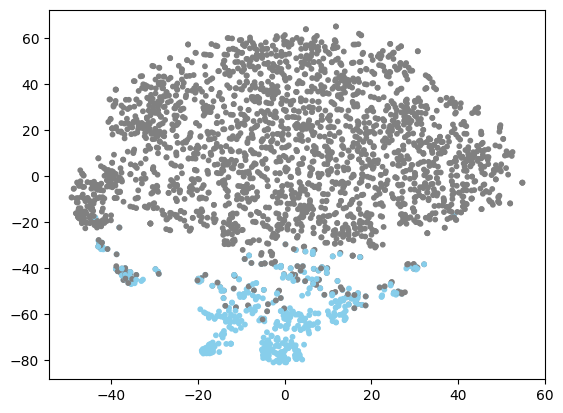

In [40]:
%matplotlib inline

X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
labelsNums = post_train_label
X_embedded= TSNE(n_components=2, init='random').fit_transform(X_np)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1] , c=labelsNums[:len(X_embedded)], s=10, cmap= cc , alpha=1 )


In [41]:
def clsembed(snippet):
    inputs = tokenizer(snippet, padding='max_length', max_length=218, truncation=True, return_tensors='pt').to(device)
    #tokens = [self.tokenizer.cls_token] + inputs  + [self.tokenizer.sep_token]
    if(len(inputs)<512):
        with torch.no_grad():
            outs = model_codebert(**inputs)
        cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
        return cls
    else:
        print('longtest')
        i = 0
        part_vector =  []
        while ( i < len(inputs)-200) :
            #tokens = [self.tokenizer.cls_token] + inputs[i:i+250] +[self.tokenizer.sep_token]
            #tokens_ids= self.tokenizer.convert_tokens_to_ids(tokens)
            input_seg = [tokenizer.cls_token] + inputs[i:i+250] +[tokenizer.sep_token]
            with torch.no_grad():
                ots = model_codebert(**input_seg)
            cls = ots.last_hidden_state[:, 0, :].squeeze().detach()
            #cls = model_codebert(torch.tensor(inputs)[None,:])[1]
            #vector = cls[0].detach().numpy()
            parts.append(cls)
            i = i+100
        return parts

In [42]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
#labels_all = ['async wait','unordered collections','concurrency','time']
def get_class_rep(post_train_embed, post_train_label):
    # Move each tensor to CPU, convert to numpy, and collect in a list
    #post_train_embed = [x.cpu().numpy() for x in post_train_embed]
    # If you want to combine them into a single array (assuming they have the same shape)
    #post_train_embed = np.concatenate(post_train_embed, axis=0)
    representatives = [None] * 2
    for label in range(2):
        indices = np.where(np.atleast_1d(post_train_label) == label)[0]  # Get the indices as an array
        class_vectors = [post_train_embed[i] for i in indices]  # Access each index individually
        class_vectors = [x.cpu().numpy() for x in class_vectors]
        representatives[label] = np.mean(class_vectors, axis=0)
    return representatives

def calculate_normalized_distance(vec1, vec2):
    # Ensure vec1 and vec2 are numpy arrays
    if not isinstance(vec1, np.ndarray):
        vec1 = vec1.cpu().detach().numpy()
    if not isinstance(vec2, np.ndarray):
        vec2 = vec2.cpu().detach().numpy()
    
    # Normalize each vector to have unit length
    norm_vec1 = vec1 / np.linalg.norm(vec1)
    norm_vec2 = vec2 / np.linalg.norm(vec2)
    
    # Calculate Euclidean (L2) distance between the normalized vectors
    distance = np.linalg.norm(norm_vec1 - norm_vec2)
    
    return distance


In [43]:
int_to_label={
    0: 'notFlaky',
    1: 'Flaky'
    }


def get_closest_cluster(cluster_representatives, projected_vector):
    distances = [calculate_normalized_distance(rep, projected_vector) for rep in cluster_representatives]
    for i in range(len(distances)):
        distances[i] = np.mean(distances[i])
    closest_cluster_idx = np.argmin(distances)
    return int_to_label[closest_cluster_idx]

In [44]:
embed = post_train_embed
labels = post_train_label
def predict(input_vector):
    modified_vector = siamese_network(input_vector)
    representatives = get_class_rep(embed, labels)
    return get_closest_cluster(representatives, modified_vector)
    


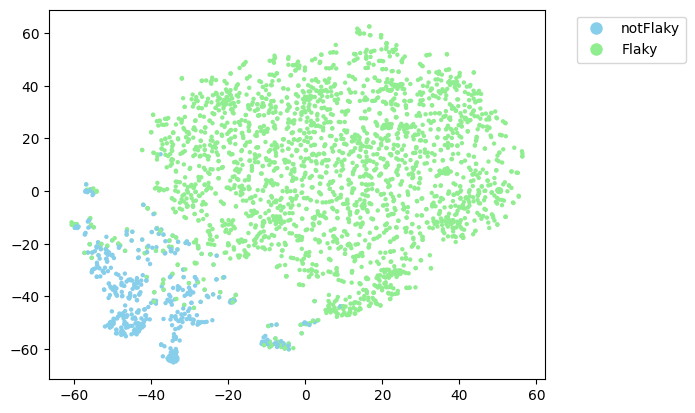

In [45]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

# Assuming post_train_embed and post_train_label are defined
X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
labelsNums = post_train_label

# Define vibrant colors for each category (same as used in the bar plot)
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid', 'grey']

# Ensure labels are within the range of colors [0, 1, 2, 3, 4]
# Filter out invalid labels (-1) and keep only valid labels [0, 1, 2, 3, 4]
valid_indices = [i for i, label in enumerate(labelsNums) if label in [0, 1]]
X_np_filtered = X_np[valid_indices]
labelsNums_filtered = [labelsNums[i] for i in valid_indices]

# Dimensionality reduction with t-SNE
X_embedded = TSNE(n_components=2, init='random').fit_transform(X_np_filtered)

# Scatter plot
for i, label in enumerate(labelsNums_filtered):
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors[label], s=10, alpha=1, edgecolor='none', marker='o')

# Create legend with category labels
legend_labels = ['notFlaky', 'Flaky']
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors], labels=legend_labels,bbox_to_anchor=(1.05, 1), 
                    loc='upper left')

plt.show()


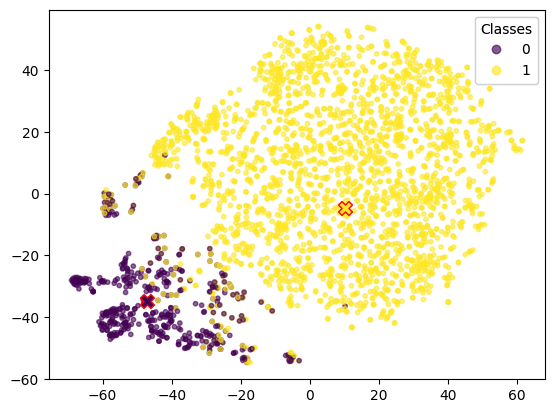

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import torch

# Assuming post_train_embed, post_train_label, and labelsNums are defined
X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
X_embedded = TSNE(n_components=2, init='random').fit_transform(X_np)

# Plot the data points
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labelsNums[:len(X_embedded)], s=10, cmap='viridis', alpha=0.6)

# Calculate class representatives
representatives = get_class_rep(post_train_embed, post_train_label)  # Make sure this function returns what you expect

# Get unique labels and their colors from the scatter plot
unique_labels = np.unique(labelsNums[:len(X_embedded)])
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# For each class representative, find the closest point and plot it
for i, rep in enumerate(representatives):
    if rep is not None:
        # Find the closest data point in the original space to this representative
        distances = np.linalg.norm(X_np - rep, axis=1)
        closest_point_index = np.argmin(distances)
        # Use the label of the closest data point to get the correct color
        label_of_closest = labelsNums[closest_point_index]
        color = scatter.cmap(scatter.norm(label_of_closest))
        plt.scatter(X_embedded[closest_point_index, 0], X_embedded[closest_point_index, 1], color=color, edgecolors='red', s=100, marker='X')

# You might want to adjust the legend to make sure it correctly represents your data
# plt.legend()
plt.show()


In [47]:
from sklearn.metrics import f1_score
# Create reverse mapping

count = 0

# Assuming val_dataset is iterable and has 'anchor' and 'label' keys
predicted_labels = []
true_labels = []

for item in val_dataset:
    count += 1
    input_vector = item['anchor']  # Your input vector for prediction
    
    # Get predicted cluster/label
    predicted_label_str = predict(input_vector)
    
    # Ensure predicted_label is in the valid range
    if predicted_label_str in label_to_int:
        predicted_label = label_to_int[predicted_label_str]
        predicted_labels.append(predicted_label)
    else:
        print(f"Warning: Encountered unknown predicted label {predicted_label_str}")
        continue

    # True label
    true_label_int = int(item['label'])  # Assuming 'label' contains the true label as integer
    if true_label_int in int_to_label:
        true_labels.append(true_label_int)
    else:
        print(f"Warning: Encountered unknown true label {true_label_int}")
        continue

    print(count, "Predicted:", predicted_label, "True:", true_label_int)

# Filter out any invalid entries where predicted or true labels are missing
valid_indices = [i for i in range(len(true_labels)) if true_labels[i] in int_to_label and predicted_labels[i] in int_to_label]
filtered_true_labels = [true_labels[i] for i in valid_indices]
filtered_predicted_labels = [predicted_labels[i] for i in valid_indices]

print("Loop completed")

# Calculate F1 Score, ignoring unknown labels
f1 = f1_score(filtered_true_labels, filtered_predicted_labels, average='weighted', zero_division=0)  # Adjust 'average' as necessary
print(f"F1 Score: {f1}")


1 Predicted: 1 True: 1
2 Predicted: 1 True: 0
3 Predicted: 1 True: 1
4 Predicted: 1 True: 1
5 Predicted: 1 True: 1
6 Predicted: 1 True: 1
7 Predicted: 1 True: 1
8 Predicted: 1 True: 0


9 Predicted: 1 True: 1
10 Predicted: 1 True: 1
11 Predicted: 1 True: 1
12 Predicted: 1 True: 0
13 Predicted: 1 True: 1
14 Predicted: 1 True: 1
15 Predicted: 0 True: 0
16 Predicted: 1 True: 1
17 Predicted: 1 True: 1
18 Predicted: 1 True: 1
19 Predicted: 1 True: 1
20 Predicted: 0 True: 0
21 Predicted: 1 True: 1
22 Predicted: 1 True: 1
23 Predicted: 1 True: 1
24 Predicted: 1 True: 1
25 Predicted: 0 True: 0
26 Predicted: 1 True: 1
27 Predicted: 1 True: 1
28 Predicted: 1 True: 1
29 Predicted: 1 True: 1
30 Predicted: 0 True: 1
31 Predicted: 1 True: 1
32 Predicted: 0 True: 0
33 Predicted: 1 True: 1
34 Predicted: 1 True: 1
35 Predicted: 1 True: 1
36 Predicted: 0 True: 0
37 Predicted: 1 True: 1
38 Predicted: 1 True: 1
39 Predicted: 1 True: 1
40 Predicted: 1 True: 0
41 Predicted: 1 True: 1
42 Predicted: 1 True: 1
43 Predicted: 1 True: 1
44 Predicted: 1 True: 1
45 Predicted: 1 True: 1
46 Predicted: 1 True: 1
47 Predicted: 1 True: 1
48 Predicted: 0 True: 1
49 Predicted: 1 True: 1
50 Predicted: 1 T

              precision    recall  f1-score   support

           0       0.50      0.58      0.54       117
           1       0.92      0.89      0.91       646

    accuracy                           0.85       763
   macro avg       0.71      0.74      0.72       763
weighted avg       0.86      0.85      0.85       763


 - Accuracy :  0.85
 - Precision :  0.86
 - Recall :  0.85
 - F1 score :  0.85
 - MCC :  0.45
 - AUC :  0.74


Performances by categories



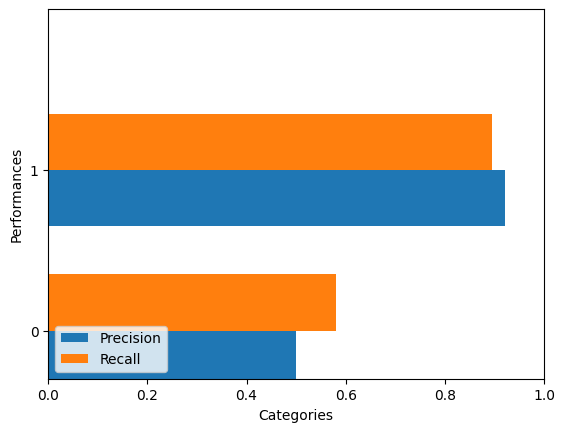



Confusion Matrix 


<AxesSubplot:>

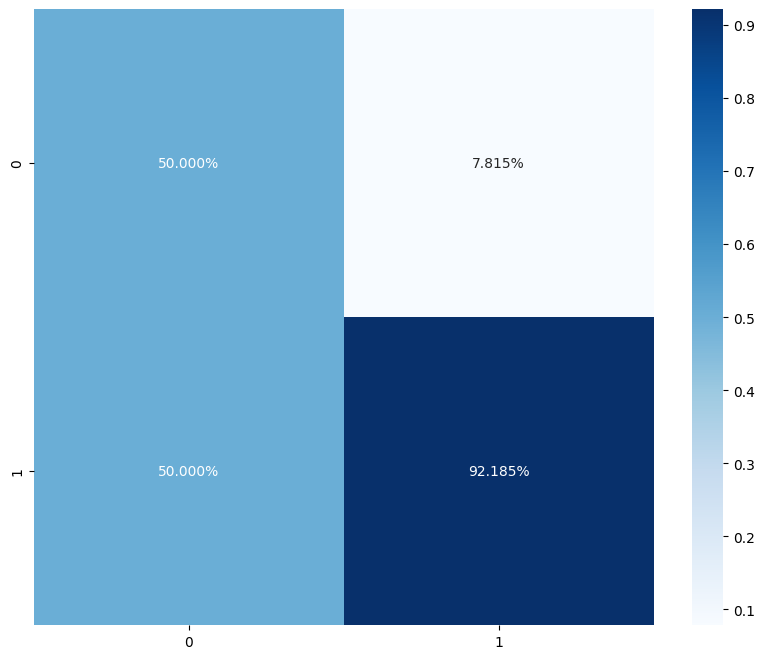

In [48]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

%matplotlib inline
warnings.filterwarnings("ignore")

def multiclass_roc_auc_score(truth, pred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)

# Assuming predicted_labels and true_labels are already defined
predicted = predicted_labels
labels = true_labels

# Filter out 'unknown' labels
valid_indices = [i for i, label in enumerate(labels) if label != 'unknown']
filtered_labels = [labels[i] for i in valid_indices]
filtered_predicted = [predicted[i] for i in valid_indices]

unique_labels = list(set(filtered_labels))
print(classification_report(filtered_labels, filtered_predicted))

print('\n - Accuracy : ', np.round(metrics.accuracy_score(filtered_labels, filtered_predicted), 2))
print(' - Precision : ', np.round(metrics.precision_score(filtered_labels, filtered_predicted, average='weighted'), 2))
print(' - Recall : ', np.round(metrics.recall_score(filtered_labels, filtered_predicted, average='weighted'), 2))
print(' - F1 score : ', np.round(metrics.f1_score(filtered_labels, filtered_predicted, average='weighted'), 2))
print(' - MCC : ', np.round(metrics.matthews_corrcoef(filtered_labels, filtered_predicted), 2))
print(' - AUC : ', np.round(multiclass_roc_auc_score(filtered_labels, filtered_predicted), 2))

print("\n\nPerformances by categories\n")

ind = np.arange(len(unique_labels)) 
width = 0.35
fig, ax = plt.subplots()
precision = metrics.precision_recall_fscore_support(filtered_labels, filtered_predicted, labels=unique_labels)[0]
recall = metrics.precision_recall_fscore_support(filtered_labels, filtered_predicted, labels=unique_labels)[1]
ax.barh(ind - width/2, precision, width, label='Precision')
ax.barh(ind + width/2, recall, width, label='Recall')
ax.set(yticks=ind, yticklabels=np.array(unique_labels), ylim=[2*width - 1, len(ind)])
plt.xlim(0, 1)
ax.legend(loc='lower left')
ax.set_ylabel("Performances")
ax.set_xlabel("Categories")
plt.show()

print("\n\nConfusion Matrix ")

mat = confusion_matrix(filtered_labels, filtered_predicted, labels=unique_labels)
df_cm = pd.DataFrame(mat, index=[i for i in unique_labels], columns=[i for i in unique_labels])
plt.figure(figsize=(10, 8))
sn.heatmap(df_cm / np.sum(df_cm), annot=True, fmt='.3%', cmap='Blues')


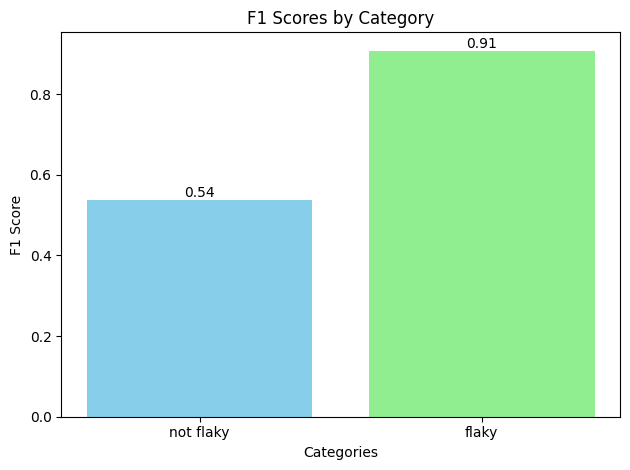

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
shortened_labels = {
    'notFlaky':'not flaky',
    'Flaky': 'flaky'
}
# Assuming you have the predicted and true labels as per your previous code
# predicted_labels and true_labels should be lists of labels
# Filter out invalid labels from both true and predicted labels
valid_indices = [i for i in range(len(true_labels)) if true_labels[i] in int_to_label.keys() and predicted_labels[i] in int_to_label.keys()]
filtered_true_labels = [true_labels[i] for i in valid_indices]
filtered_predicted_labels = [predicted_labels[i] for i in valid_indices]

# Calculate F1 scores for each category
f1_scores = []
categories = list(int_to_label.keys())
for category in categories:
    true_bin = [1 if label == category else 0 for label in filtered_true_labels]
    pred_bin = [1 if label == category else 0 for label in filtered_predicted_labels]
    f1 = f1_score(true_bin, pred_bin, zero_division=0)
    f1_scores.append(f1)

# Define vibrant colors for each category
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid', 'grey']

# Create bar plot with shortened category names and vibrant colors
shortened_categories = [shortened_labels[int_to_label[category]] for category in categories]
fig, ax = plt.subplots()
bars = ax.bar(shortened_categories, f1_scores, color=colors)

# Add F1 scores on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 0),  
                textcoords="offset points", ha='center', va='bottom')

# Customize the plot
ax.set_xlabel('Categories')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Scores by Category')

# Display the plot
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
